## Loading and Preparation of Dataset

In [2]:
import os
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [3]:
# Define dataset path and get folder names as labels
data_path = "./Data/Aerial_Landscapes"
labels = os.listdir(data_path)
print(labels)
image_paths = []
image_labels = []

# Traverse dataset directory and get all image files in folders
for label in labels:
    folder_path = os.path.join(data_path, label)
    for image_file in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, image_file))
        image_labels.append(label)

# Print first image path and label
print(f'Image Path: {image_paths[0]} | Label: {image_labels[0]}')

# Check if image_paths and image_labels are the same length
print(f'Total images: {len(image_paths)}, Total labels: {len(image_labels)}')

['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']
Image Path: ./Data/Aerial_Landscapes\Agriculture\001.jpg | Label: Agriculture
Total images: 12000, Total labels: 12000


In [4]:
# Create a LabelEncoder to convert labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(labels)  # Fit encoder to all unique labels

# Convert image labels to integer indices
image_labels = label_encoder.transform(image_labels)

In [5]:
# Custom Dataset Class for our project or task
class ImageDataset(Dataset):
    # Initialize the dataset with image paths, labels, and optional transformations
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Get label
        label = self.image_labels[idx]

        return image, label

In [6]:
# Create a temporary dataset to calculate the mean and std
basic_transform = transforms.Compose([transforms.ToTensor()])

temp_dataset = ImageDataset(image_paths, image_labels, transform=basic_transform)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=0)

# Calculate mean and std
mean = 0.0
std = 0.0
total_images = 0

for images, _ in temp_loader:
    images = images.view(images.size(0), images.size(1), -1)  # Flatten each image batch
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += images.size(0)

mean /= total_images
std /= total_images

print("Calculated Mean:", mean)
print("Calculated Std:", std)

Calculated Mean: tensor([0.3781, 0.3930, 0.3445])
Calculated Std: tensor([0.1353, 0.1230, 0.1177])


In [7]:
# Split into train and temp (validation + test) sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels, random_state=42)

# Split temp into validation and test sets
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Print the sizes of each set
print(f'Training set size: {len(train_paths)}')
print(f'Validation set size: {len(val_paths)}')
print(f'Test set size: {len(test_paths)}')
# 70% training, 15% validation, and 15% test data.

Training set size: 8400
Validation set size: 1800
Test set size: 1800


In [8]:
# Define the transform using the calculated mean and std
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels (adjust as needed)
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())  # Normalize with calculated mean and std
])

In [9]:
# Create datasets
train_dataset = ImageDataset(train_paths, train_labels, transform=transform)
val_dataset = ImageDataset(val_paths, val_labels, transform=transform)
test_dataset = ImageDataset(test_paths, test_labels, transform=transform)

In [10]:
# Hyperparameters
batch_size = 256
num_workers = 0 # I would choose perhaps 8 based on GPU capability, but only 0 works with no freeze

In [11]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Data loaded successfully!


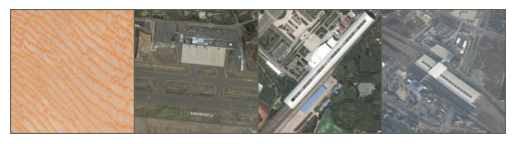

Labels:  Desert Airport Railway Railway


In [12]:
# Function to unnormalize and visualize a batch of images
def imshow(img, mean, std):
    # Unnormalize the image
    img = img * std[:, None, None] + mean[:, None, None]  # Reshape mean and std for broadcasting
    img = np.clip(img, 0, 1)  # Clip to [0, 1] to avoid clipping warnings
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axes
    plt.show()

# Get a batch of training data, if working correctly
try:
    dataiter = iter(train_loader)
    images, label = next(dataiter)
    print("Data loaded successfully!")
except Exception as e:
    print(f"Error loading data: {e}")

# Define mean and std for unnormalization
mean = torch.tensor([0.3781, 0.3930, 0.3445])
std = torch.tensor([0.1353, 0.1230, 0.1177])

# Select a batch of 4 images and labels
image_batch = images[0:4]
label_batch = label[0:4]

# Show the 4 images
imshow(torchvision.utils.make_grid(image_batch), mean, std)

# Print the labels for the current batch of images
print('Labels: ', ' '.join(f'{labels[j]}' for j in label_batch))

## Loading models

In [13]:
import torch.nn as nn
from torchvision import models

# Set number of output classes
num_classes = 15

# Load pretrained AlexNet model
AlexNet_default = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
AlexNet_random = models.alexnet()

# Load pretrained VGG16 model
VGG16_default = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
VGG16_random = models.vgg16()

# Load pretrained ResNet34 model
ResNet34_default = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
ResNet34_random = models.resnet34()

# Change number of output classes to 15
AlexNet_default.classifier[6] = nn.Linear(AlexNet_default.classifier[6].in_features, num_classes)
AlexNet_random.classifier[6] = nn.Linear(AlexNet_random.classifier[6].in_features, num_classes)
VGG16_default.classifier[6] = nn.Linear(VGG16_default.classifier[6].in_features, num_classes)
VGG16_random.classifier[6] = nn.Linear(VGG16_random.classifier[6].in_features, num_classes)
ResNet34_default.fc = nn.Linear(ResNet34_default.fc.in_features, num_classes)
ResNet34_random.fc = nn.Linear(ResNet34_random.fc.in_features, num_classes)

In [14]:
import torch.optim as optim

'''  Decide if the calculations are perfomed by GPU or CPU  '''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
'''.to(device): moves tensors and models to the specified device (either GPU or CPU).
This ensures that all computations happen on the same device, avoiding errors or inefficiencies.'''
print(f"Selected device: {device}")
# Cross Entropy Loss for multi-class classification
criterion = nn.CrossEntropyLoss()
''' L2 Regularization adds a penalty proportional to the square of the magnitude
 of the weights to the loss function. Discourages the model from assigning
  too much importance to any individual feature by keeping the weights small.
 The larger the weight, the higher the penalty.'''

# Learning rate and weight decay (L2 regularization)
lr = 0.0001
weight_decay = 0.0005
num_epochs = 10

Selected device: cuda


In [15]:
def training(model, epochs):
    # Initialize lists to store training and validation metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            ''' torch.max(outputs, 1): The torch.max() function returns the maximum
            value of all elements in the tensor along a specified dimension.
            (_) is used for variables that we don't need to use   '''
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        # append the list
        train_losses.append(train_loss)
        train_accuracy = 100 * correct / total
        # append the list
        train_accuracies.append(train_accuracy)

        # .eval indicates that the model is used for prediction.
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    return train_losses, val_losses, train_accuracies, val_accuracies

In [16]:
train_losses, val_losses, train_accuracies, val_accuracies = training(AlexNet_default, num_epochs)

Epoch 1/10, Train Loss: 0.7987, Train Accuracy: 74.88%, Val Loss: 0.2988, Val Accuracy: 89.94%
Epoch 2/10, Train Loss: 0.2129, Train Accuracy: 93.30%, Val Loss: 0.2127, Val Accuracy: 92.83%
Epoch 3/10, Train Loss: 0.1127, Train Accuracy: 96.27%, Val Loss: 0.2078, Val Accuracy: 93.67%
Epoch 4/10, Train Loss: 0.0755, Train Accuracy: 97.55%, Val Loss: 0.2151, Val Accuracy: 93.44%
Epoch 5/10, Train Loss: 0.0472, Train Accuracy: 98.61%, Val Loss: 0.2146, Val Accuracy: 94.28%
Epoch 6/10, Train Loss: 0.0256, Train Accuracy: 99.15%, Val Loss: 0.2586, Val Accuracy: 94.11%
Epoch 7/10, Train Loss: 0.0297, Train Accuracy: 98.99%, Val Loss: 0.1999, Val Accuracy: 94.28%
Epoch 8/10, Train Loss: 0.0233, Train Accuracy: 99.19%, Val Loss: 0.2201, Val Accuracy: 94.44%
Epoch 9/10, Train Loss: 0.0345, Train Accuracy: 98.92%, Val Loss: 0.2374, Val Accuracy: 94.22%
Epoch 10/10, Train Loss: 0.0254, Train Accuracy: 99.24%, Val Loss: 0.2399, Val Accuracy: 94.06%


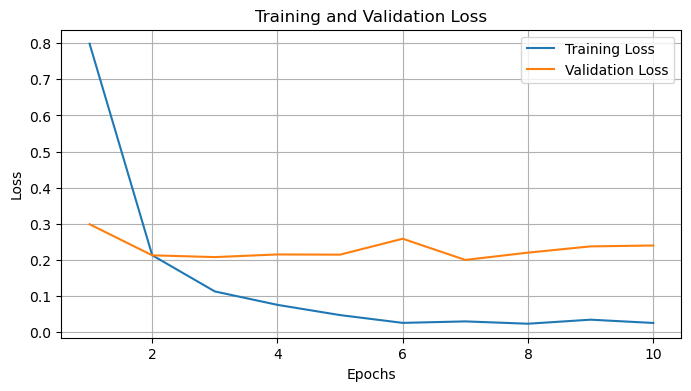

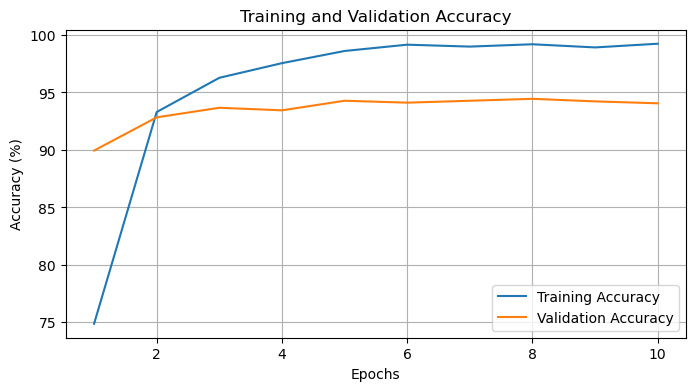

In [17]:
# Plot training and validation loss
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()